## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAdjustSharpness, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *
from architecture.AutoEncoder import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

## Prepare Dataset

In [3]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1),
                          RandomAdjustSharpness(2, p=1),
                          ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [4]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

## Testing CNN

Here, we test the checkpoint made at 6 epochs when training the CNN as it has the lowest validation loss before training was stopped at 9 epochs, as well as the model saved at 8 epochs due to a high validation accuracy >= 90%.

In [8]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# sharp sobel kernels (will have to update if kernel size increases)
# these will be the starting weights of the convolutional layers
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [1, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

### Testing the checkpoint made at 6 epochs

In [14]:
cnn_model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear).to(device)
cnn_model.load_state_dict(torch.load('./DeepLearn_6epochs')["model_state_dict"])
for param in cnn_model.parameters():
    param.requiresGrad = False

Test loss: 0.3776, Test accuracy: 0.8530
Precision: 0.8501026694045175
Recall: 0.9695550351288056
F1 score: 0.9059080962800875


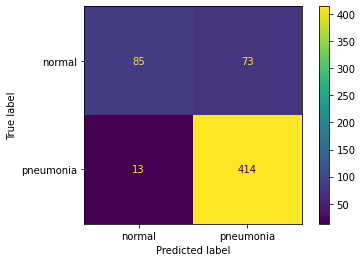

In [16]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=cnn_model, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

### Testing the save made at 8 epochs

In [17]:
cnn_model.load_state_dict(torch.load('./DeepLearn_8epochs')["model_state_dict"])
for param in cnn_model.parameters():
    param.requiresGrad = False

Test loss: 0.3688, Test accuracy: 0.8735
Precision: 0.8747346072186837
Recall: 0.9648711943793911
F1 score: 0.9175946547884186


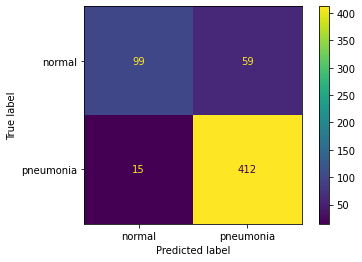

In [19]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=cnn_model, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Load AutoEncoder

In [23]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [24]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_4epochs")["model_state_dict"])
for param in autoencmodel.parameters():
    param.requiresGrad = False

## CNN with AutoEncoder

Since there was only one checkpoint made for the CNN trained with the autoencoder, load and test it.

In [20]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# sharp sobel kernels (will have to update if kernel size increases)
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [256, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [21]:
# checkpoint saved at 11 epochs
cnn_model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear, dropout=0.5).to(device)
cnn_model.load_state_dict(torch.load('./DeepLearn_checkpoint_withAE')["model_state_dict"])
for param in cnn_model.parameters():
    param.requiresGrad = False

Test loss: 0.4214, Test accuracy: 0.8188
Precision: 0.8422174840085288
Recall: 0.9250585480093677
F1 score: 0.8816964285714285


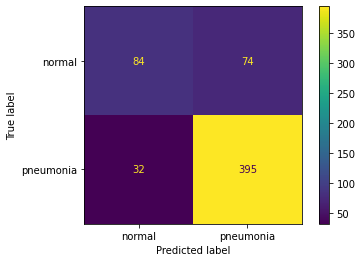

In [22]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=cnn_model, 
                                                          data_loader=test_loader, autoencoder=autoencmodel,
                                                          get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)